## Dependencies

In [1]:
include("XFZ18.jl")
using Plots

┌ Warning: 
│ 
│     # Breaking changes
│ 
│     `TaylorIntegration.jl` follows now (≥ v0.5.0) the convention
│     of `DifferentialEquations.jl` for the function containing
│     the differential equation to be integrated. The function
│     must have the form `f(x, p, t)` for one dependent variable,
│     or `f!(dx, x, p, t)` for several dependent variables, where
│     `dx` is mutated.
│ 
└ @ TaylorIntegration /Users/forets/.julia/dev/TaylorIntegration/src/TaylorIntegration.jl:21
┌ Info: Recompiling stale cache file /Users/forets/.julia/compiled/v1.1/Reachability/CHV4V.ji for Reachability [774a0091-654f-5c65-bbdc-ad5b67b45832]
└ @ Base loading.jl:1184
┌ Warning: 
│ 
│     # Breaking changes
│ 
│     `TaylorIntegration.jl` follows now (≥ v0.5.0) the convention
│     of `DifferentialEquations.jl` for the function containing
│     the differential equation to be integrated. The function
│     must have the form `f(x, p, t)` for one dependent variable,
│     or `f!(dx, x, p, t)` for sev

## Experiment 1: Van der Pol, μ = 0.2

In [2]:
@polyvar x₁ x₂  x\_3  t

# XFZ18
f = [x₂, -0.2*x₁ + x₂ - 0.2*x₁^2*x₂, x₂^2 - x_3]
S = PolynomialContinuousSystem(f, 2)

PolynomialContinuousSystem{Float64,Polynomial{true,Float64},Array{Polynomial{true,Float64},1}}(Polynomial{true,Float64}[x₂, -0.2x₁²x₂ - 0.2x₁ + x₂], 2)

In [38]:
q = 5
g = q^2 - x₁^2 - x₂^2 # Y = {x: g(x) >= 0} compact search space Y x [0, T]

opts = Options(:T => 2.0, :relaxation_degree => 12,
               :solver=>MosekTools.Mosek.Optimizer,
               :V0 => x₁^2 + x₂^2 - 0.25, # X0 = {x: V0(x) <= 0}
               :g => g, # Y = {x: g(x) >= 0} compact search space Y x [0, T]
               :t => t,
               :verbose => false,
               :domain => (@set g >= 0))

Options(Dict{Symbol,Any}(:T=>2.0,:verbose=>false,:V0=>x₁² + x₂² - 0.25,:solver=>Optimizer,:domain=>BasicSemialgebraicSet{Float64,Polynomial{true,Float64},AlgebraicSet{Float64,Polynomial{true,Float64},Buchberger,SolverUsingMultiplicationMatrices{GröbnerBasisMultiplicationMatricesAlgorithm,ReorderedSchurMultiplicationMatricesSolver{Int64,MersenneTwister}}}}(Algebraic Set defined by no equality
, Polynomial{true,Float64}[-x₁² - x₂² + 25.0]),:g=>-x₁² - x₂² + 25,:t=>t,:relaxation_degree=>12))

### Computing $\Phi(x, t)$

In [39]:
model = build_sos(S, opts);
solve!(model, true)
MOI.get(model, MOI.SolveTime())

JuMP.termination_status(model) = SLOW_PROGRESS
JuMP.primal_status(model) = FEASIBLE_POINT
JuMP.dual_status(model) = FEASIBLE_POINT
JuMP.objective_bound(model) = 0.0
JuMP.objective_value(model) = 0.07207466360246793


5.824086904525757

In [ ]:
#Φ = JuMP.value(model[:Φ]);
# p1 = subs(Φ[1], x₂=>0, t=>0)+1;
#variables(Φ)

### Extracting the approximations

In [40]:
Φ = JuMP.value(model[:Φ]);
F = extract(model, opts);

In [ ]:
Φ

In [41]:
#F.over

In [42]:
using ImplicitPlots, Makie

In [43]:
Iplot = ImplicitPlots.plot(F.over, x_min=-10, x_max=10);

In [44]:
display(ImplicitPlots.plot!(Iplot, F.under, x_min=-10, x_max=10))

GLMakie.Screen(...)

In [26]:
display(ImplicitPlots.plot(x₁^2 +x₂^2 - 1 ))

GLMakie.Screen(...)

In [46]:
maxdegree(F.over)

12

In [ ]:
d = [1.0, 0.0]
variables(dot(d, variables(F.over)))

In [ ]:
ρ_sublevel(F.over, [1.0, 0.0], opts)

### Real roots of the under and over approx

In [17]:
# preallocate output
sol_vec = Vector{Vector{Float64}}()
x₂_max = 4.0
Δ = 0.02
@time rroots_2d!(sol_vec, F.under, x₂_max, Δ);
println("number of solutions = ", length(sol_vec))

  0.620614 seconds (645.78 k allocations: 72.771 MiB, 8.37% gc time)
number of solutions = 288


In [20]:
first(sol_vec)

2-element Array{Float64,1}:
 8.113362381128322
 4.0              

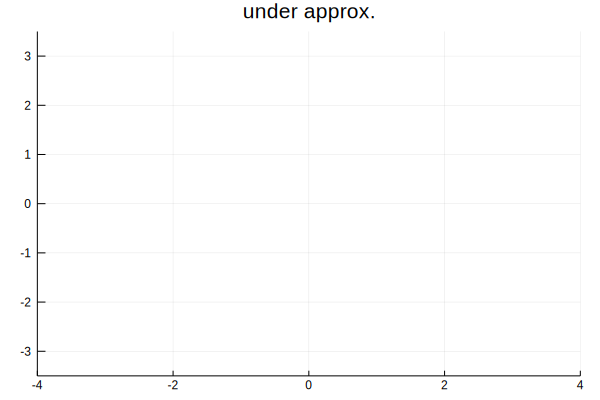

In [19]:
Plots.plot([Singleton(si) for si in sol_vec], color=:green, marker=:square, title="under approx.",
            xlims=(-4,4), ylims=(-3.5,3.5))

In [ ]:
# preallocate output
sol_vec = Vector{Vector{Float64}}()
#x₂_max = 3.0
#Δ = 0.1
@time rroots_2d!(sol_vec, F.over, x₂_max, Δ);
println("number of solutions = ", length(sol_vec))

In [ ]:
plot!([Singleton(si) for si in sol_vec], color=:blue, marker=:cross, title="over approx.")

In [ ]:
B0 = BallInf([0.0, 0.0], 0.5)
B2 = BallInf([5.0, 0.0], 0.5)
#plot!([B0, B2], color=:red)

In [ ]:
[subs(F.over, (x₁, x₂) => vi) for vi in vertices_list(B0)]

In [ ]:
using IntervalConstraintProgramming

In [ ]:
#_F(x, y) = subs(F.over, x^2 + y^2 - 1 < 0
S = Separator(variables(F.over), F.over((x₁, x₂)) < 0);
D = IntervalBox(-2..2, 2)
pa = pave(S, D, 0.05);

## Experiment 2: Van der Pol, μ = 1.0

In [ ]:
@polyvar x₁ x₂ t

# ARCH-COMP
const μ = 1.0
f =  [x₂, μ*(1-x₁^2)*x₂ - x₁] 
S = PolynomialContinuousSystem(f, 2)

In [ ]:
H0 = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45]) # initial set from ARCHCOMP

#X0 = Hyperrectangle(low=[0.6, 1.0], high=[0.8, 1.1]) # 

#X0 = Hyperrectangle(low=[-0.5, -0.5], high=[0.5, 0.5]) # set from XFZ18

plot(X0, color=:red, alpha=.5)

Bc = LazySets.center(X0)
Br = norm(LazySets.radius_hyperrectangle(X0))
B0 = Ball2(Bc, Br)
plot!(B0, 1e-4, alpha=.2, ratio=1., color=:blue)

In [ ]:
#g = 6 - x₁^2 - x₂^2 # Y = {x: g(x) >= 0} compact search space Y x [0, T]
q = 5.0

# centered around initial condition
#g = (B0.radius+q)^2 - (x₁-B0.center[1])^2 - (x₂-B0.center[2])^2 # Y = {x: g(x) >= 0} compact search space Y x [0, T]

# centered around origin
g = q^2 - x₁^2 - x₂^2 # Y = {x: g(x) >= 0} compact search space Y x [0, T]

η = 1.0 # re-scale B0?
opts = Options(:T => 7.0, :relaxation_degree => 6,
               :solver=>MosekTools.Mosek.Optimizer,
               :V0 => (x₁-B0.center[1])^2 + (x₂-B0.center[2])^2 - B0.radius^2*η^2, # X0 = {x: V0(x) <= 0}
               :g => g, # Y = {x: g(x) >= 0} compact search space Y x [0, T]
               :t => t,
               :verbose => false,
               :domain => (@set g >= 0))

In [ ]:
model = build_sos(S, opts);
solve!(model, true)
MOI.get(model, MOI.SolveTime())

In [ ]:
F = extract(model, opts);

In [ ]:
# preallocate output
sol_vec = Vector{Vector{Float64}}()
x₂_max = 5.0
Δ = 0.2
@time rroots_2d!(sol_vec, F.under, x₂_max, Δ);
println("number of solutions = ", length(sol_vec))

In [ ]:
plot([Singleton(si) for si in sol_vec], color=:green, marker=:square, title="under approx.")

In [ ]:
# preallocate output
sol_vec = Vector{Vector{Float64}}()
x₂_max = 5.0
Δ = 0.05
@time rroots_2d!(sol_vec, F.over, x₂_max, Δ);
println("number of solutions = ", length(sol_vec))

In [ ]:
plot([Singleton(si) for si in sol_vec], color=:blue, marker=:cross, title="over approx.")

## Experiment 18. dai_gan_xhia_zhan_jsc14_ex1

In [ ]:
@polyvar x y t
initially = @set 1/100 - x^2 - y^2 >= 0
forbidden = @set x^2 + y^2 >= 1/4
time_horizon = 9
invariant = Universe(2)
flow = [-2*x+x^2+y, x-2*y+y^2]
S = PolynomialContinuousSystem(flow, 2)

g = -x^2 - y^2 + 0.5
opts = Options(:T => 2.0, :relaxation_degree => 8,
               :solver=>MosekTools.Mosek.Optimizer,
               :V0 => -1/100 + x^2 + y^2, # X0 = {x: V0(x) <= 0}
               :g => g, # Y = {x: g(x) >= 0} compact search space Y x [0, T]
               :t => t,
               :verbose => false,
               :domain => (@set g >= 0))

model = build_sos(S, opts);
solve!(model, true)
@show MOI.get(model, MOI.SolveTime())

F = extract(model, opts);

In [ ]:
# preallocate output
sol_vec = Vector{Vector{Float64}}()
x₂_max = 0.5
Δ = 0.01
@time rroots_2d!(sol_vec, F.under, x₂_max, Δ);
println("number of solutions = ", length(sol_vec))
plot([Singleton(si) for si in sol_vec], color=:green, marker=:square, title="under approx.")

In [ ]:
# preallocate output
sol_vec = Vector{Vector{Float64}}()
#x₂_max = 1.0
#Δ = 0.01
@time rroots_2d!(sol_vec, F.over, x₂_max, Δ);
println("number of solutions = ", length(sol_vec))
plot!([Singleton(si) for si in sol_vec], color=:blue, marker=:cross, title="over approx.")

In [ ]:
subs(F.over, (x, y) => (0.0, 0.0))

---

### EXAMPLE 2.1 in SOGOKON

|Relax. order k|$\epsilon$|Runtime (sec)|
|---|----|----|
|15|2.78|15|
|16|1.85|36|
|17|1.54|38|
|18|1.42|78|

In [ ]:
@polyvar x y t
initially = @set x^2 + (y+2)^2 - 1 <= 0
forbidden = @set x^2 + (y-1)^2 <= 9/100
time_horizon = 9
invariant = Universe(2)
flow = [2*x - x * y, 2*x^2 - y]
S = PolynomialContinuousSystem(flow, 2)

g = - x^2 - y^2 + 10.0
opts = Options(:T => 2.0, :relaxation_degree => 18,
               :solver=>MosekTools.Mosek.Optimizer,
               :V0 => x^2 + (y+2)^2 - 1, # X0 = {x: V0(x) <= 0}
               :g => g, # Y = {x: g(x) >= 0} compact search space Y x [0, T]
               :t => t,
               :verbose => false,
               :domain => (@set g >= 0))

model = build_sos(S, opts);
solve!(model, true)
@show MOI.get(model, MOI.SolveTime())

F = extract(model, opts);

--- 

## Other experiments

In [ ]:
@polyvar x₁ x₂ x₃ t

opts = Options(:T => 3.0,
               :relaxation_degree=>4,
               :solver=>Mosek.Optimizer,
               :V0 => 100*(x₁^2 + x₂^2 + x₃^2) - 1.0,
               :g => 0.16 - (x₁^2 + x₂^2 + x₃^2),
               :verbose=>false)

f =  [-x₁*x₂ + x₁*x₃, -x₂*x₃ + x₂*x₁, -x₃*x₁ + x₃*x₂]
S = PolynomialContinuousSystem(f, 3)

In [ ]:
model = build_sos(S, opts);
solve!(model, true)